In [1]:
from importlib import reload as rel
import os, numpy as np, pandas as pd, datetime as dt, matplotlib.pyplot as plt, time
cwd = os.getcwd()
if cwd.find('src') != len(cwd)-3:
    if cwd.find('algoview') == len(cwd)-8:
        os.chdir(cwd + '/src')
    elif len(cwd) > cwd.find('src')+3:
        os.chdir(cwd[:cwd.find('src')+3])
    else: print('Warning: cannot resolve path')
import queue, collections, trading.utils as utils, trading.functions as fn, database as db
import trading.LiveMktData as lmd, trading.OrderPlacement as op, trading.AccountPositions as ap

#### Simulated inputs (from extension)

In [2]:
underlying = 'USO'
msg = 'n=entryL1 d=long t=m p=0 q=1 u=1 c=10000 b=1h'

#### Format Backtest data from TV

In [3]:
TV_data = pd.read_excel(r'/Users/nicolas/Projects/algoview/Strategies.xlsm', sheet_name='For Python')
order_params = utils.parse_message(msg)

tot_len = TV_data['Date/Time'].max() - TV_data['Date/Time'].min()

if tot_len.days > 280:
    durationStr = str(int(tot_len.days/365) + 1) + ' Y'
elif tot_len.days / 30 < 1:
    durationStr = str(int(tot_len.days) + 1) + ' D'
else:
    durationStr = str(int(tot_len.days / 30 + 1)) + ' M'

app = fn.reconnect()['app']
contract_dets = fn.make_contract(app, underlying)
hist_mkt_data = app.get_IB_historical_data(contract_dets['ibcontract'], durationStr, barSizeSetting=db.bar_to_str[order_params['b']])
app.disconnect()

price_data = pd.DataFrame(hist_mkt_data, columns=['Date', 'O', 'H', 'L', 'C', 'V'])
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.set_index('Date', inplace=True)
price_data['Price'] = price_data['O'] #round(( price_data['O'] + price_data['C'] ) / 2, 2)
price_data.drop(labels=['O','H','L','C','V'], axis=1, inplace=True)

df = utils.date_range(start=TV_data['Date/Time'].min(), end=TV_data['Date/Time'].max(), bar_size=order_params['b'])
df.set_index('Date', inplace=True)

IB error id -1 errorcode 2107 string HMDS data farm connection is inactive but should be available upon demand.ushmds.nj
IB error id -1 errorcode 2107 string HMDS data farm connection is inactive but should be available upon demand.ushmds
IB error id -1 errorcode 2106 string HMDS data farm connection is OK:ushmds.nj


In [4]:
nb_item = len(TV_data)
contract_list = []
for i, row in TV_data.iterrows():                    ## Correct the Contracts column
    sign = 1
    if row.Type == 'Entry Short' or row.Type == 'Exit Long':
        sign = -1
    if np.isnan(row.Contracts) and i<nb_item-1:
        contract_list.append(sign * TV_data['Contracts'][i+1])
    else:
        contract_list.append(sign * row.Contracts)
    
new = pd.DataFrame({'Contracts': contract_list})
TV_data['Contracts'] = new['Contracts']             ## Replace the Contracts column by the corrected one

TV_data.drop(['Trade #','Type','Signal','Profit', 'Price'], axis=1, inplace=True)
TV_data = TV_data.drop_duplicates(['Date/Time', 'Contracts']).groupby('Date/Time').agg(sum)  ## Aggregate contracts traded on each date (no duplicates)
#  TV_data = TV_data.drop_duplicates(['Date/Time', 'Contracts']).groupby('Date/Time').agg(['min', 'sum'])  ## Aggregate contracts traded on each date (no duplicates)
TV_data.index.names = ['Date']
#  TV_data = pd.DataFrame({'Contracts': TV_data['Contracts']['sum'], 'Price': TV_data['Price']['min']}, index=TV_data.index)

In [5]:
df2 = df.join(price_data).fillna(method='ffill')
df3 = df2.join(TV_data).fillna(value=0)
df3['Position'] = df3['Contracts'].cumsum().shift(1)  ## Inferring positions at each time from the Contracts column
df4 = df3.drop('Contracts', axis=1).fillna(0)
df4['PnL'] = df4['Position'] * ( df4['Price'] - df4['Price'].shift(1) )
df4['Perf'] = df4['PnL'].cumsum()

In [20]:
df4[600:].head()

,Price,Position,PnL,Perf
Date,,,,
2018-01-28 15:30:00,13.25,7466.0,0.0,5447.97
2018-01-28 16:30:00,13.25,7466.0,0.0,5447.97
2018-01-28 17:30:00,13.25,7466.0,0.0,5447.97
2018-01-28 18:30:00,13.25,7466.0,0.0,5447.97
2018-01-28 19:30:00,13.25,7466.0,0.0,5447.97


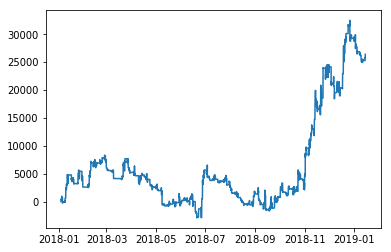

In [10]:
plt.plot(df4['Perf'])

In [7]:
## OLD

df2 = df.join(TV_data)
df2.fillna(value=0, inplace=True)
df2['Position'] = df2['Contracts'].cumsum().shift(1)
df2.drop('Contracts', axis=1, inplace=True)
df3 = df2.join(price_data)
df3['PnL'] = df3['Position'] * ( df3['Price'] - df3['Price'].shift(1) )
df3['Perf'] = df3['PnL'].cumsum()

#### Main.py

In [3]:
start_time = time.time()

error = None
info = None
fill_status = False
avg_price = 0
orderid1 = None

try:
    app = fn.reconnect()['app']
    contract_dets = fn.make_contract(app, underlying)
    order1 = fn.make_order(app, contract_dets, msg)

    if order1.totalQuantity != 0:
        orderid1 = app.place_new_IB_order(
            contract_dets['ibcontract'], order1, orderid=None)
        fill_dets = fn.check_fill(app, order1, orderid1)
        fill_status = fill_dets['fill_status']
        avg_price = fill_dets['price']
    else:
        info = "Nothing to trade"
    
    exec_df = fn.get_execDetails(app)
    orders_df = fn.get_openOrders(app)
    
    app.disconnect()
except Exception as Exc:
    app.disconnect()
    error = Exc

end_time = time.time()

IB error id -1 errorcode 2107 string HMDS data farm connection is inactive but should be available upon demand.njhmds.nj
IB error id -1 errorcode 2107 string HMDS data farm connection is inactive but should be available upon demand.njhmds
IB error id -1 errorcode 2106 string HMDS data farm connection is OK:cashhmds
IB error id 50 errorcode 366 string No historical data query found for ticker id:50


In [4]:
exec_df.tail()

,underlying,OrderId,AvgPrice,Shares,conId,ClientId
time,,,,,,
20190114 13:30:15,EURUSD,63,1.14619,81070,12087792,1
20190114 13:31:16,EURUSD,64,1.14614,81070,12087792,1
20190114 13:32:17,EURUSD,65,1.14631,81070,12087792,1
20190114 13:33:18,EURUSD,66,1.14618,81070,12087792,1
20190114 13:39:04,EURUSD,67,1.14603,81070,12087792,1


In [5]:
orders_df.tail()

,status,underlying,direction,order type,quantity,price,filled,avg fill px,conId,ClientId


In [18]:
app = fn.reconnect()['app']
app.cancel_all_orders()
app.disconnect()

IB error id -1 errorcode 2106 string HMDS data farm connection is OK:njhmds.nj
IB error id -1 errorcode 2107 string HMDS data farm connection is inactive but should be available upon demand.njhmds
IB error id -1 errorcode 2106 string HMDS data farm connection is OK:cashhmds
IB error id 59 errorcode 161 string Cancel attempted when order is not in a cancellable state.  Order permId =821852069
IB error id 58 errorcode 202 string Order Canceled - reason:


#### Historical Market Data

In [ ]:
app = fn.reconnect()['app']
contract_dets = fn.make_contract(app, underlying)
hist_mkt_data = app.get_IB_historical_data(contract_dets['ibcontract'], durationStr='2 D', barSizeSetting='1 hour')
app.disconnect()

#### Account Positions

In [ ]:
app = fn.reconnect()['app']

## lets get positions
positions_list = app.get_current_positions()
print(positions_list)

## get the account name from the position
## normally you would know your account name
accountName = positions_list[0][0] #'DU486001'

## and accounting information
accounting_values = app.get_accounting_values(accountName)
print(accounting_values)

## these values are cached
## if we ask again in more than 5 minutes it will update everything
accounting_updates = app.get_accounting_updates(accountName)
print(accounting_updates)

app.disconnect()